# SGS Analytical Methods

This notebook focuses on analytical methods and assumes you provide real input data (no synthetic fallbacks).


## Setup and User Data Paths

Provide file paths to your data files (GeoTIFF, GeoJSON, or GeoPackage). All paths used below are required.


In [1]:
# =============================================================================
# USER CONFIGURATION
# =============================================================================
DATA_CONFIG = {
    # Rasters
    "continuous_raster_path": 'data/raster/spectral/idx_clay_hydroxyls.tif',
    "categorical_raster_path": None,  # GeoTIFF with class labels

    # Vector data
    "vector_path": 'data/vector/lithology.geojson', 
    "geochem_points_path": 'data/vector/geochem.geojson', 

    # Raster data
    "spectral_indices_dir": 'data/raster/spectral', 
    "geophysics_dir": 'data/raster/geophys',  

    # Prospectivity mapping
    "prospectivity_feature_rasters": [],  # List of raster paths (GeoTIFF)
    "prospectivity_training_points_path": None,  # GeoJSON with known deposits
}



## Imports


In [2]:
import helpers as h


## Load Helpers and Prepare Data


In [3]:
data = h.load_training_data(DATA_CONFIG)

continuous_raster = data['continuous_raster']
raster_extent = data['raster_extent']
raster_crs = data['raster_crs']
vector_gdf = data['vector_gdf']
categorical_raster = data['categorical_raster']
geochem_gdf = data['geochem_gdf']

feature_cols, value_col = h.prepare_geochem_features(geochem_gdf)


Raster shape: (351, 396)
Vector records: 463
Geochem records: 1243


## Analytical Methods


### Interpolation (IDW + Kriging)


In [4]:
interp_inputs = h.prepare_interpolation_inputs(geochem_gdf, value_col)
sample_coords, sample_values, grid_points, grid_shape, interp_extent = interp_inputs


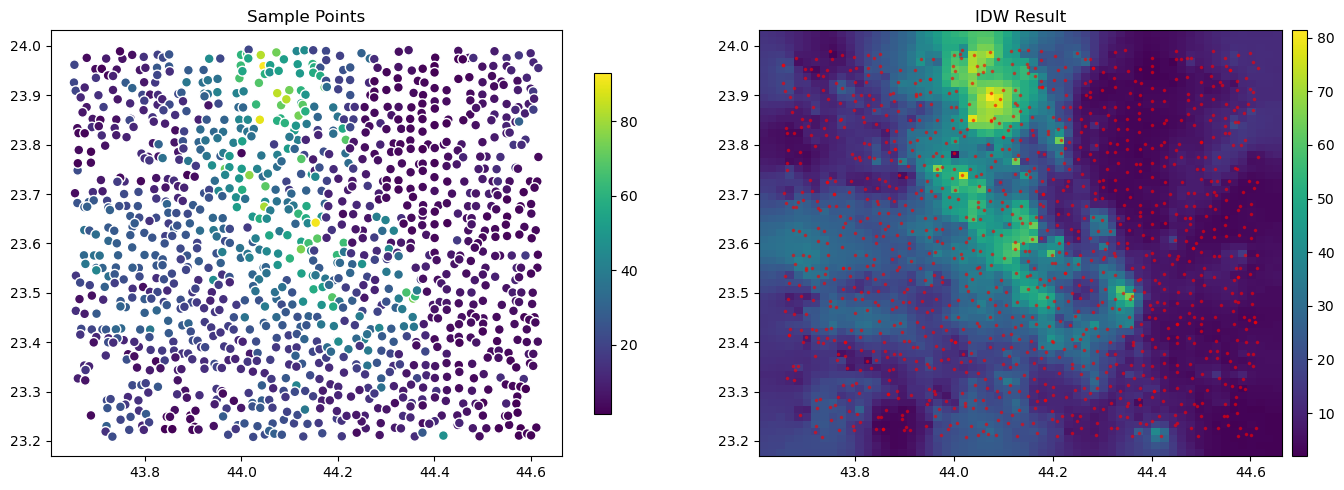

In [5]:
idw_grid = h.run_idw_interpolation(
    sample_coords, sample_values, grid_points, grid_shape, interp_extent
)


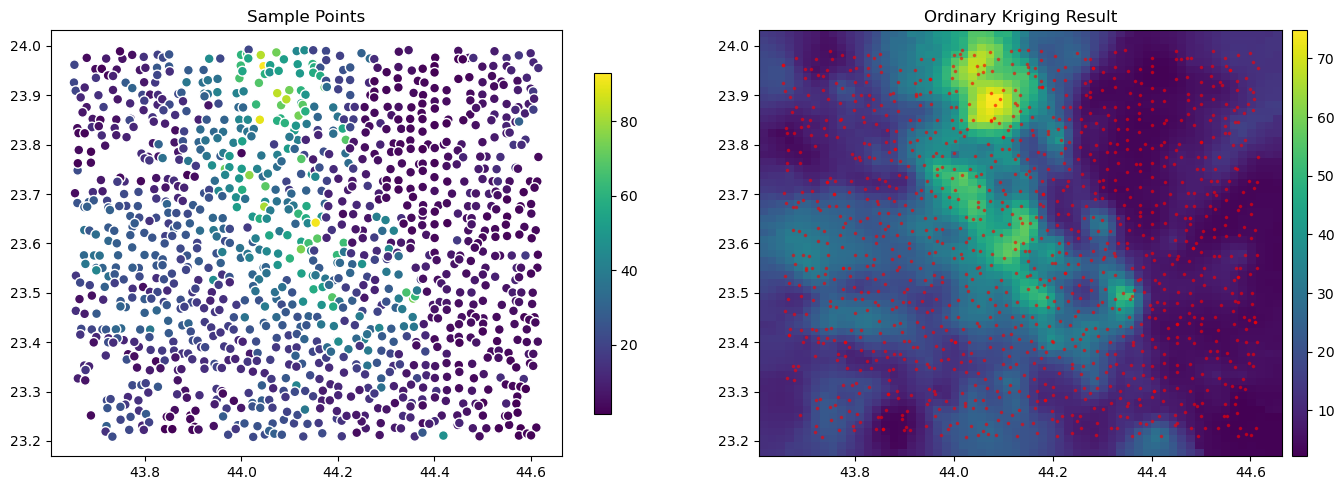

In [6]:
kriging_grid, kriging_var = h.run_kriging_interpolation(
    sample_coords, sample_values, grid_points, grid_shape, interp_extent
)


### PCA


In [7]:
pca_inputs = h.prepare_pca_inputs(geochem_gdf, feature_cols)
X_scaled = pca_inputs['X_scaled']
pca_cols = pca_inputs['pca_cols']


Original dimensions: 57


In [8]:
pca, X_pca = h.fit_pca_model(X_scaled)


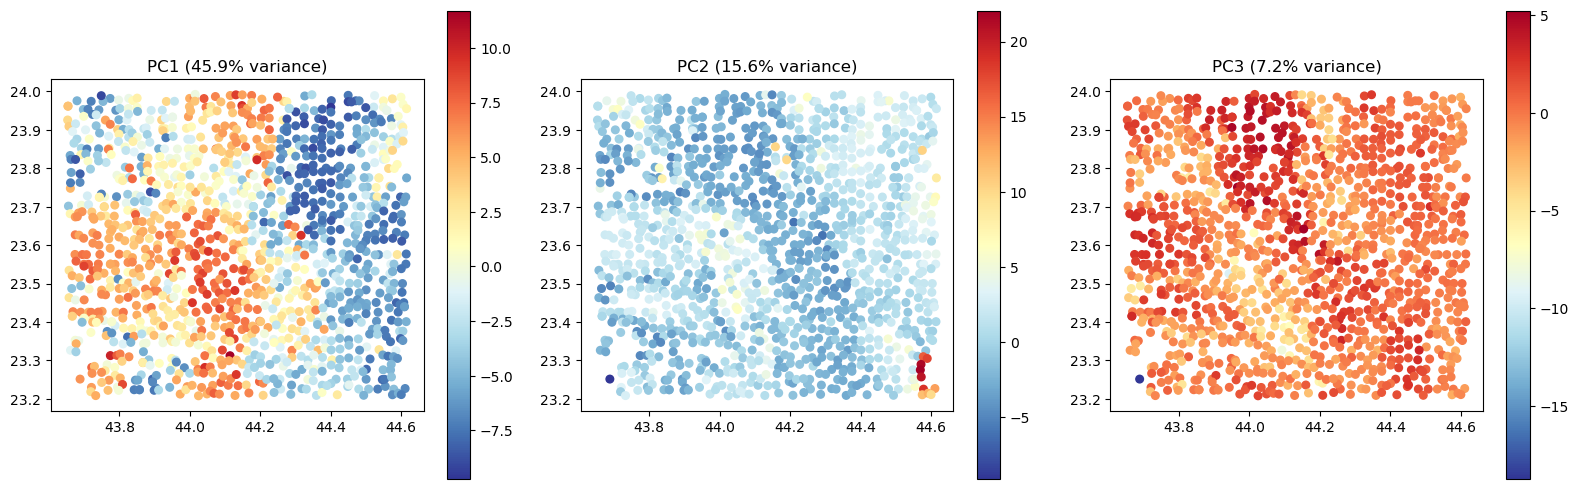

In [10]:
_ = h.plot_spatial_pca_components(geochem_gdf, X_pca, pca)
h.show_plot()


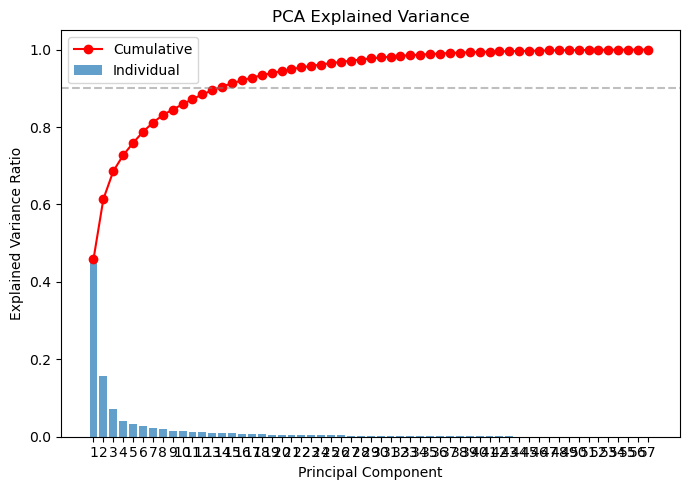

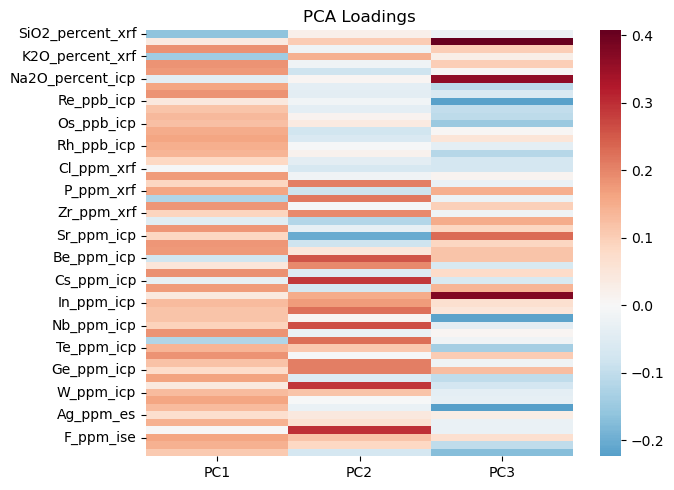

In [9]:
_ = h.plot_pca_variance(pca)
_ = h.plot_pca_loadings(pca, pca_cols)
h.show_plot()


### K-means (Geochemical Populations)


In [11]:
cluster_labels = h.run_kmeans_clustering(X_scaled, n_clusters=4)


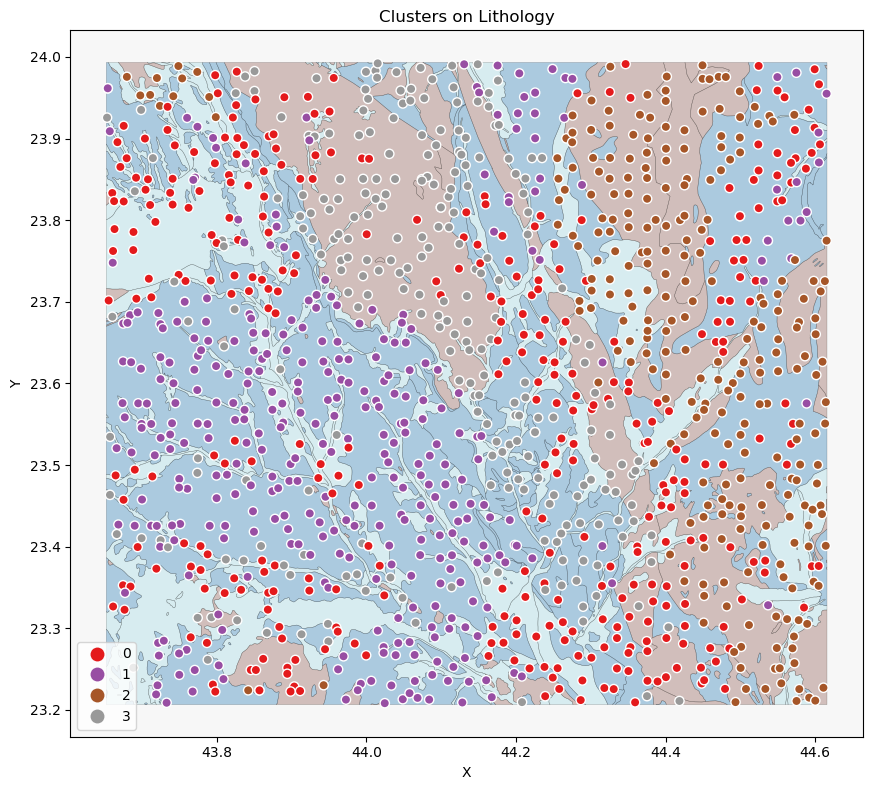

In [12]:
_ = h.plot_clusters_on_lithology(vector_gdf, geochem_gdf, cluster_labels)
h.show_plot()


### Multivariate Anomaly Detection (Isolation Forest)

See full reference implementation in `anomaly_detection/`.


In [13]:
X_anom, anom_cols = h.prepare_anomaly_inputs(geochem_gdf, feature_cols)


In [14]:
anom_labels, anom_scores = h.fit_isolation_forest_model(X_anom)


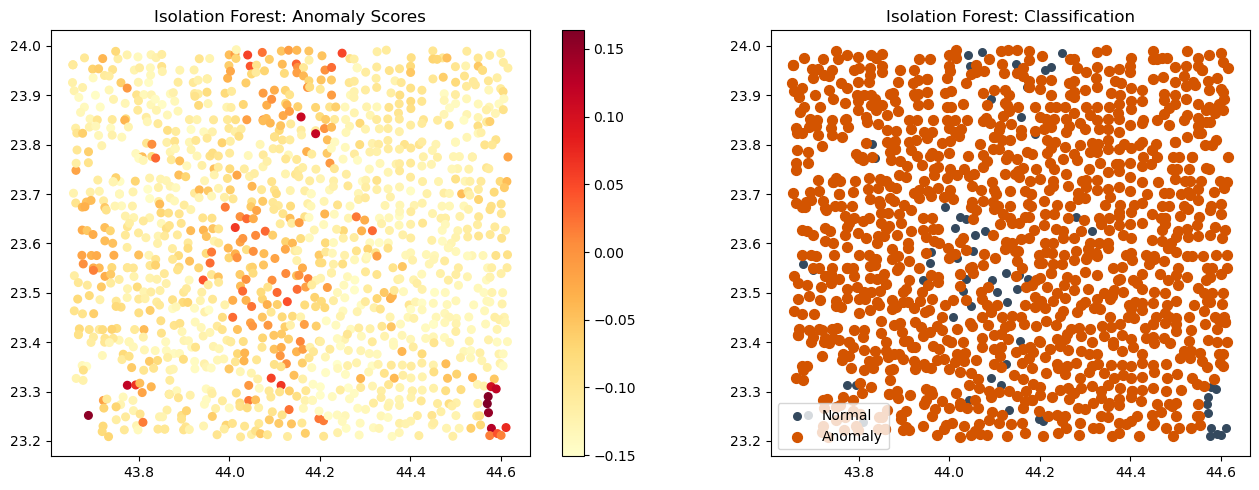

In [15]:
_ = h.plot_anomaly_scores(geochem_gdf, anom_scores, binary_labels=anom_labels, title='Isolation Forest')
h.show_plot()


### Spectral Halo Classification

See full reference implementation in `MinersWork/spectral_unsupervised/spectral_unsupervised_class.ipynb`.


Use indices like clay/Al-OH, iron oxide (ferric), ferrous iron, silica, gossan, and laterite. Sentinel-2 does not provide a direct carbonate index, so these act as proxies.


In [16]:
spectral_indices, spectral_extent = h.load_spectral_indices_dir(DATA_CONFIG['spectral_indices_dir'])


/Users/thowe/Documents/Work/SGS_training/helpers.py:2374: RuntimeWarning: Mean of empty slice
  mapped[canon] = np.nanmean(stacked, axis=0)


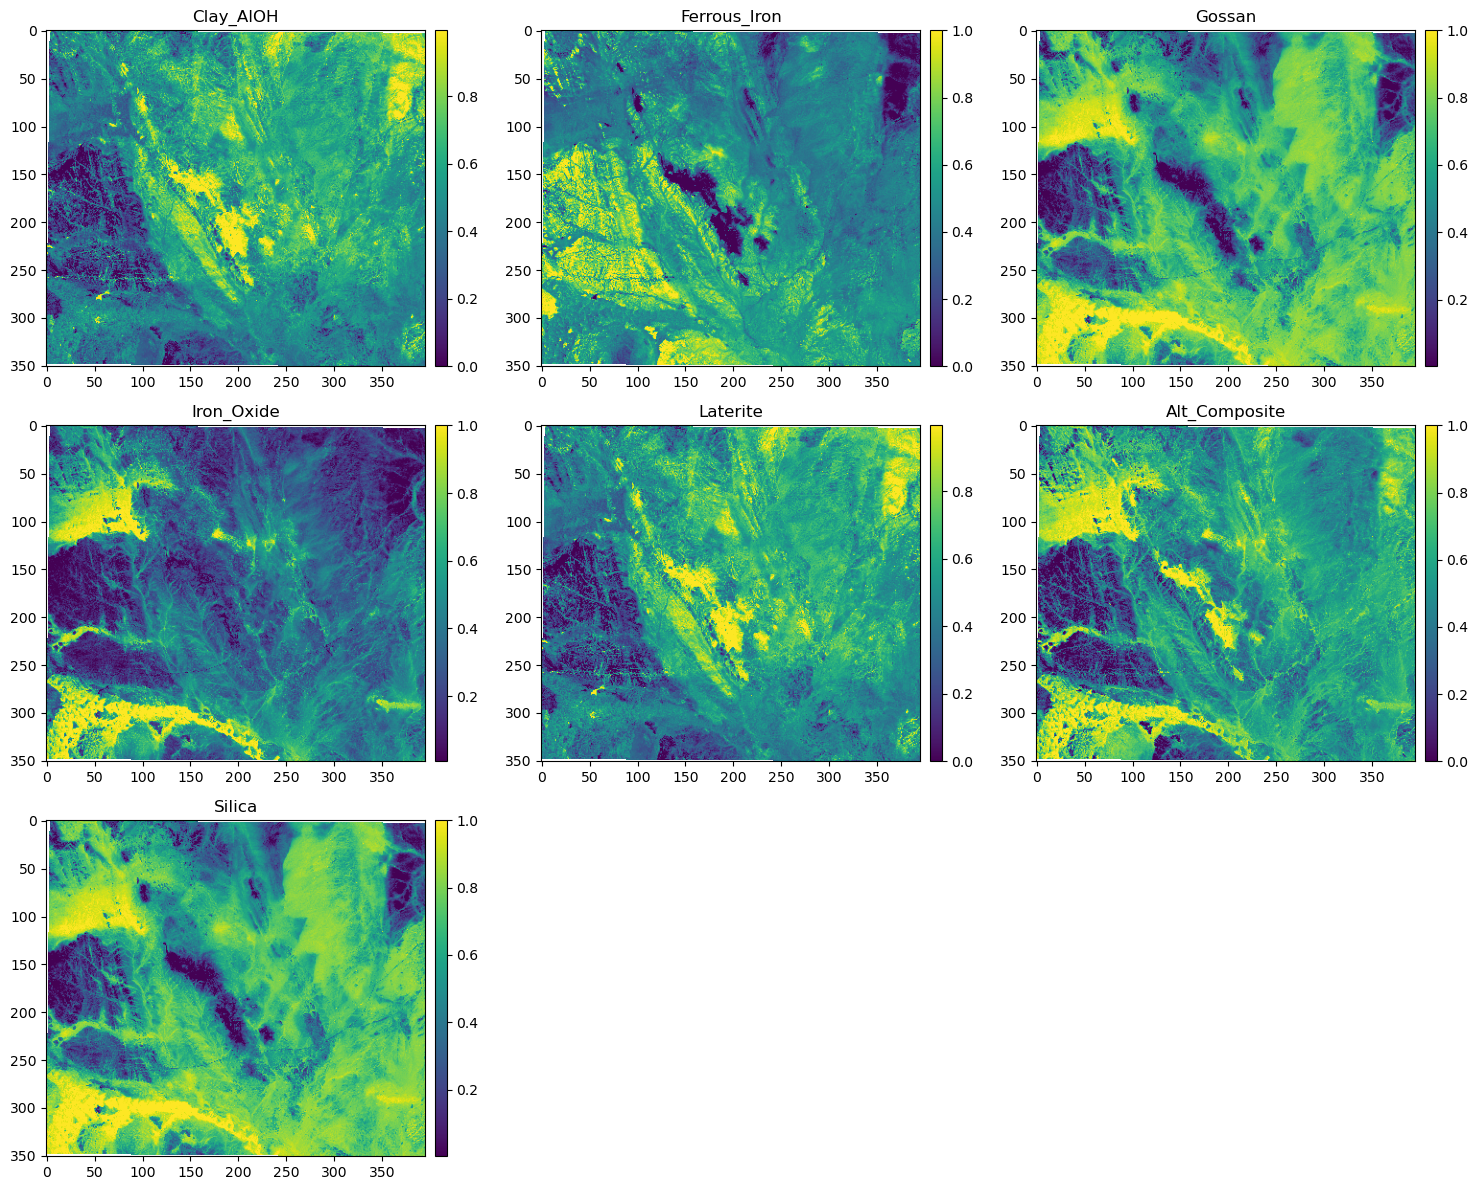

In [17]:
spectral_indices = h.map_spectral_indices(spectral_indices)
valid_mask = h.spectral_valid_mask(spectral_indices)
_ = h.plot_spectral_indices_grid(spectral_indices)
h.show_plot()


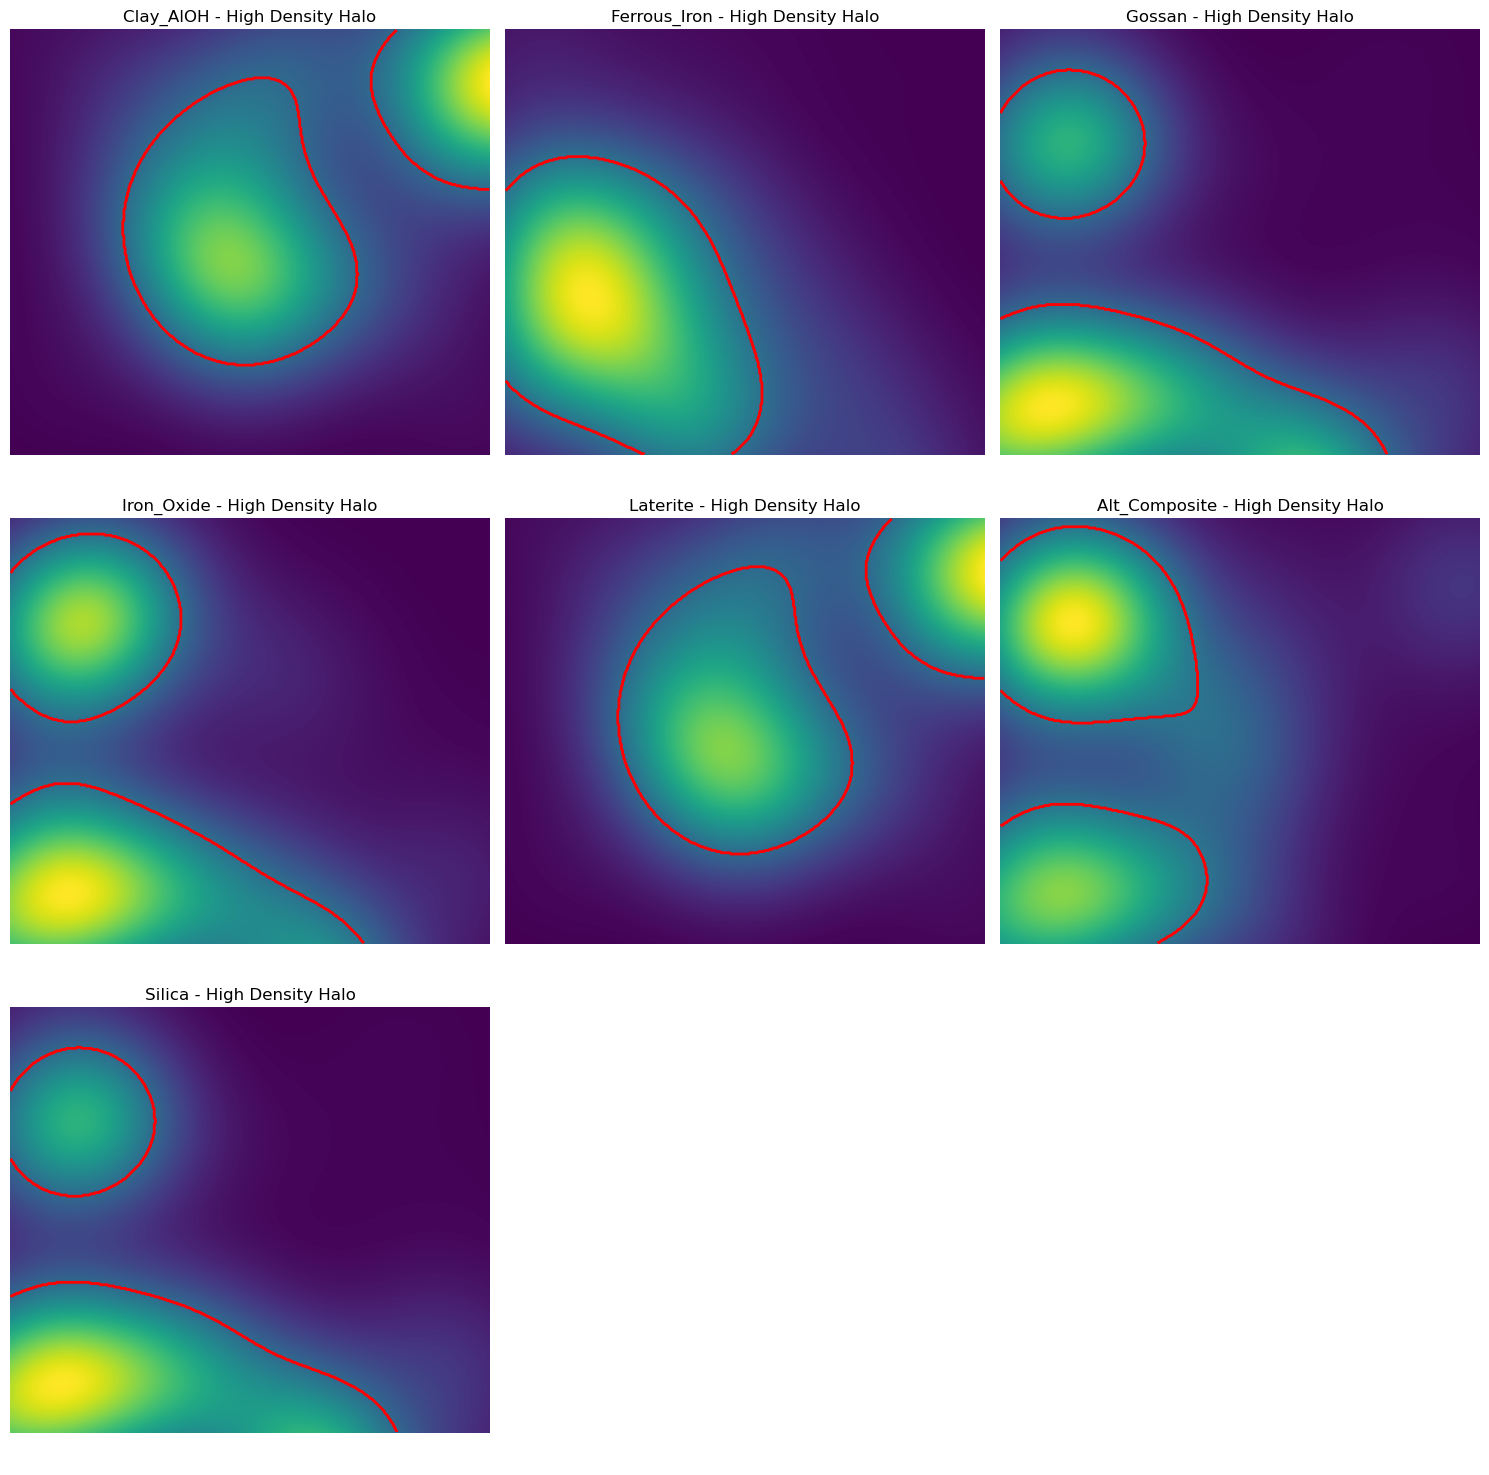

In [18]:
kde_surfaces, halo_masks = h.run_halo_detection_workflow(
    spectral_indices,
    presence_quantile=0.9,
    sigma_px=50,
    clip_q=(0.01, 0.99),
    valid_mask=valid_mask,
)
_ = h.plot_halo_detection_results(kde_surfaces, halo_masks)
h.show_plot()


Alteration type classes:
0: Background
1: Advanced Argillic (5039 pixels, 3.6%)
2: Phyllic (18365 pixels, 13.2%)
3: Argillic (12389 pixels, 8.9%)
4: Propylitic (28326 pixels, 20.4%)
5: Gossan (12242 pixels, 8.8%)
6: Laterite (33643 pixels, 24.2%)


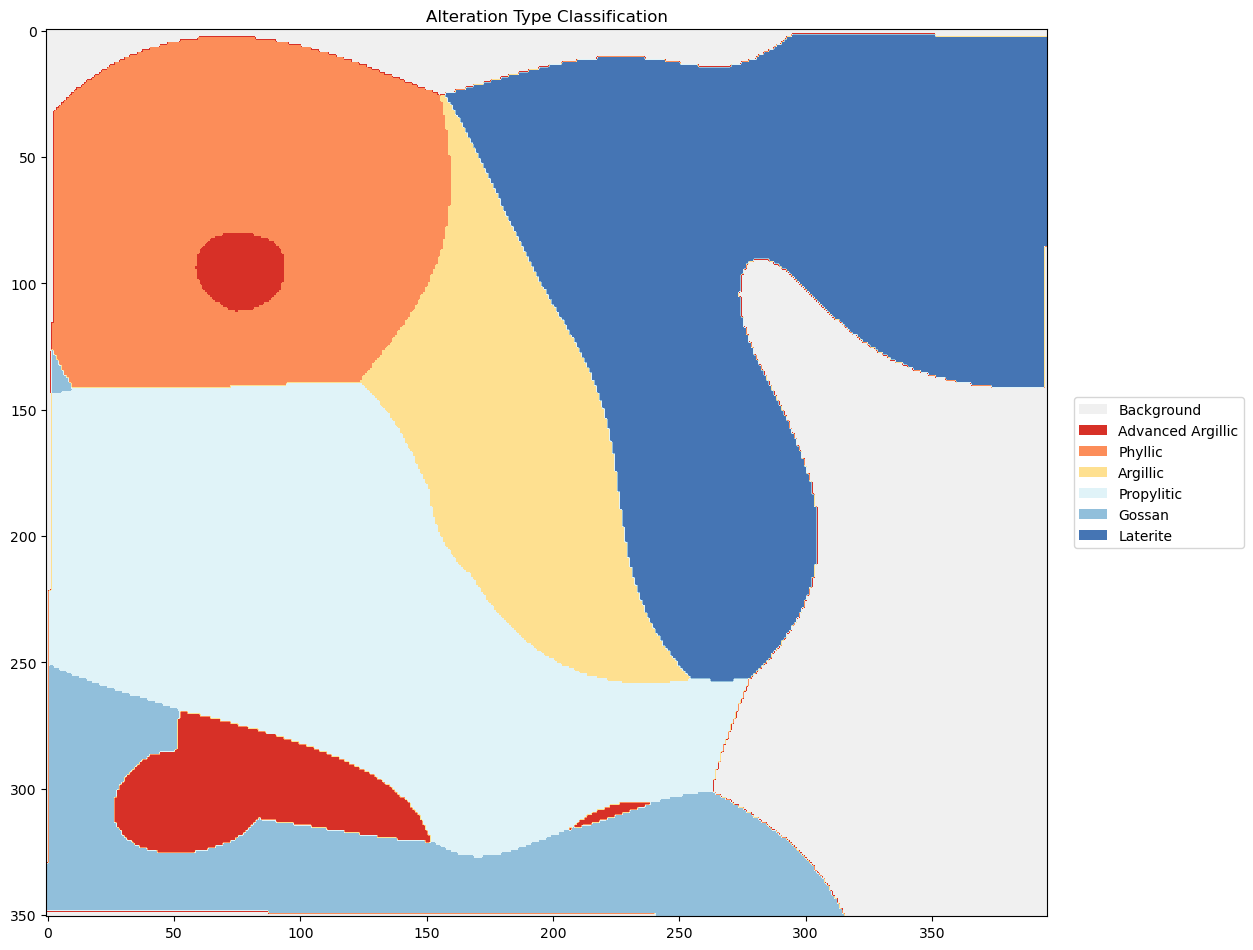

In [19]:
alteration_weights = h.default_alteration_weights()
class_map, class_names, alteration_scores = h.classify_alteration_types(
    kde_surfaces,
    alteration_weights,
    valid_mask=valid_mask,
    confidence_percentile=20,
)
h.summarize_alteration_classes(class_map, class_names)
_ = h.plot_alteration_map(class_map, class_names=class_names, figsize=(12, 10))
h.show_plot()


### Supervised ML Prospectivity Mapping

See full reference implementation in `supervised_ML/`.


Loaded data cube from: data/ML/DCG.nc


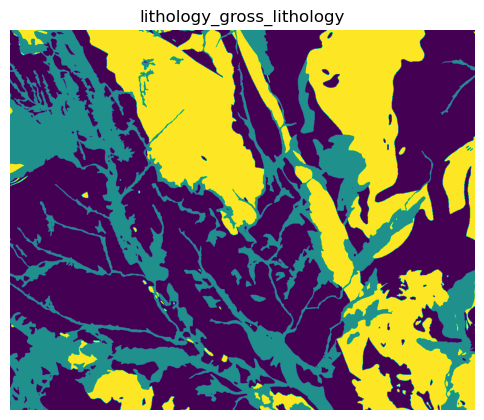

In [20]:
h.display_data_cube_viewer('data/ML')


Loaded workflow artifacts from: data/ML


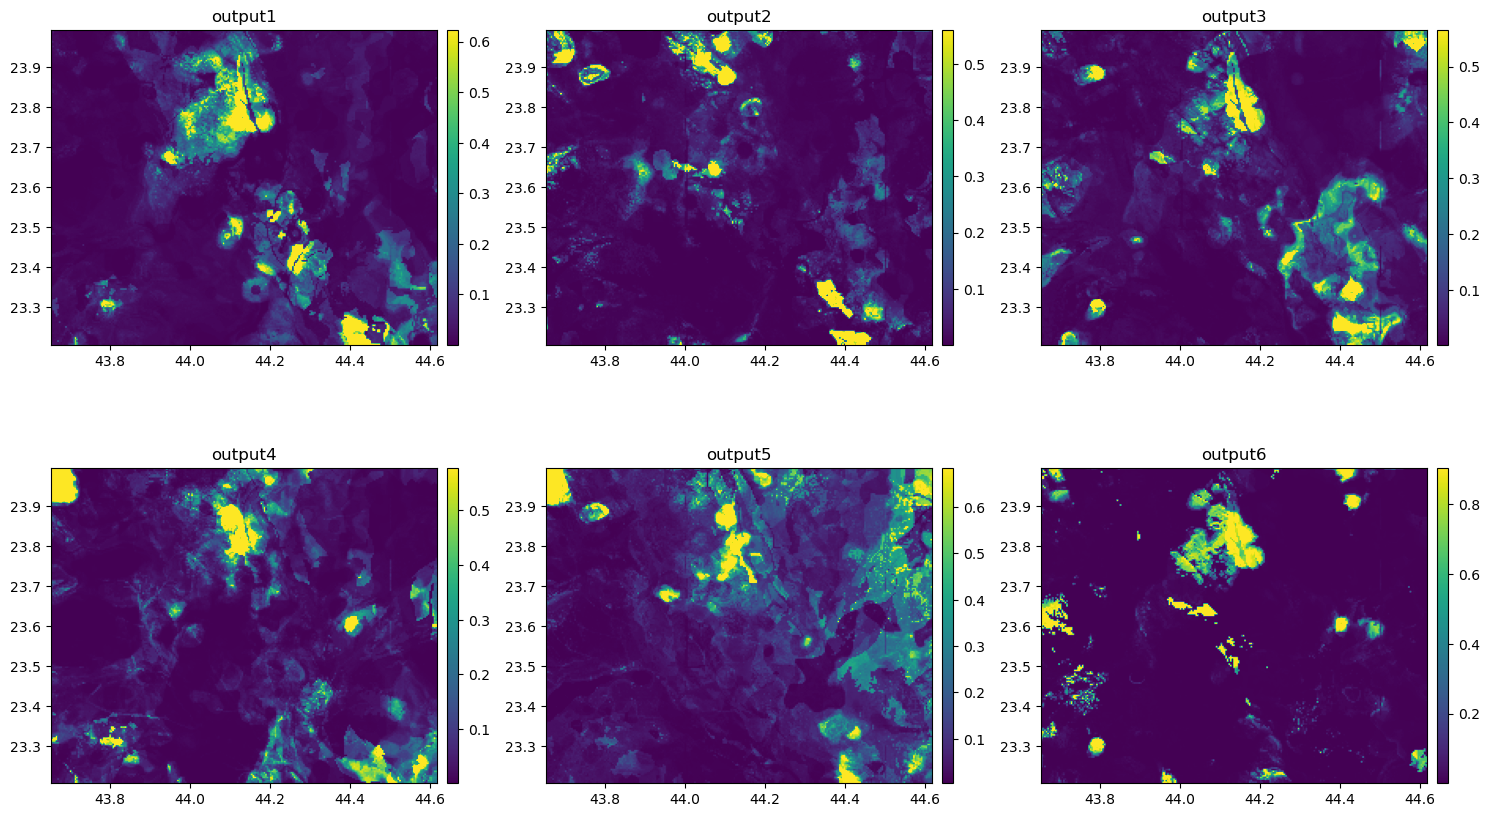

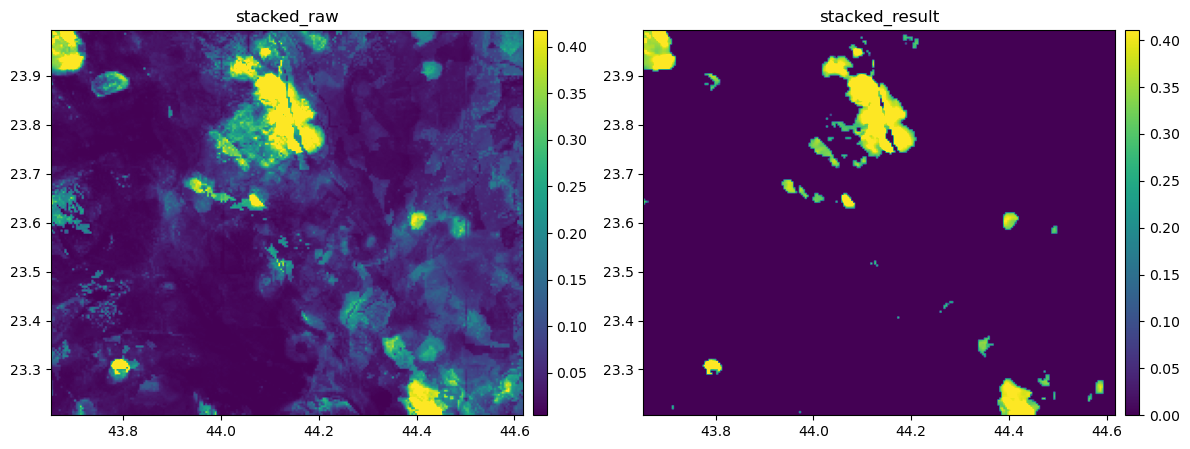

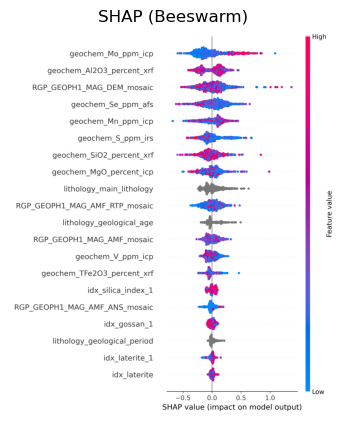

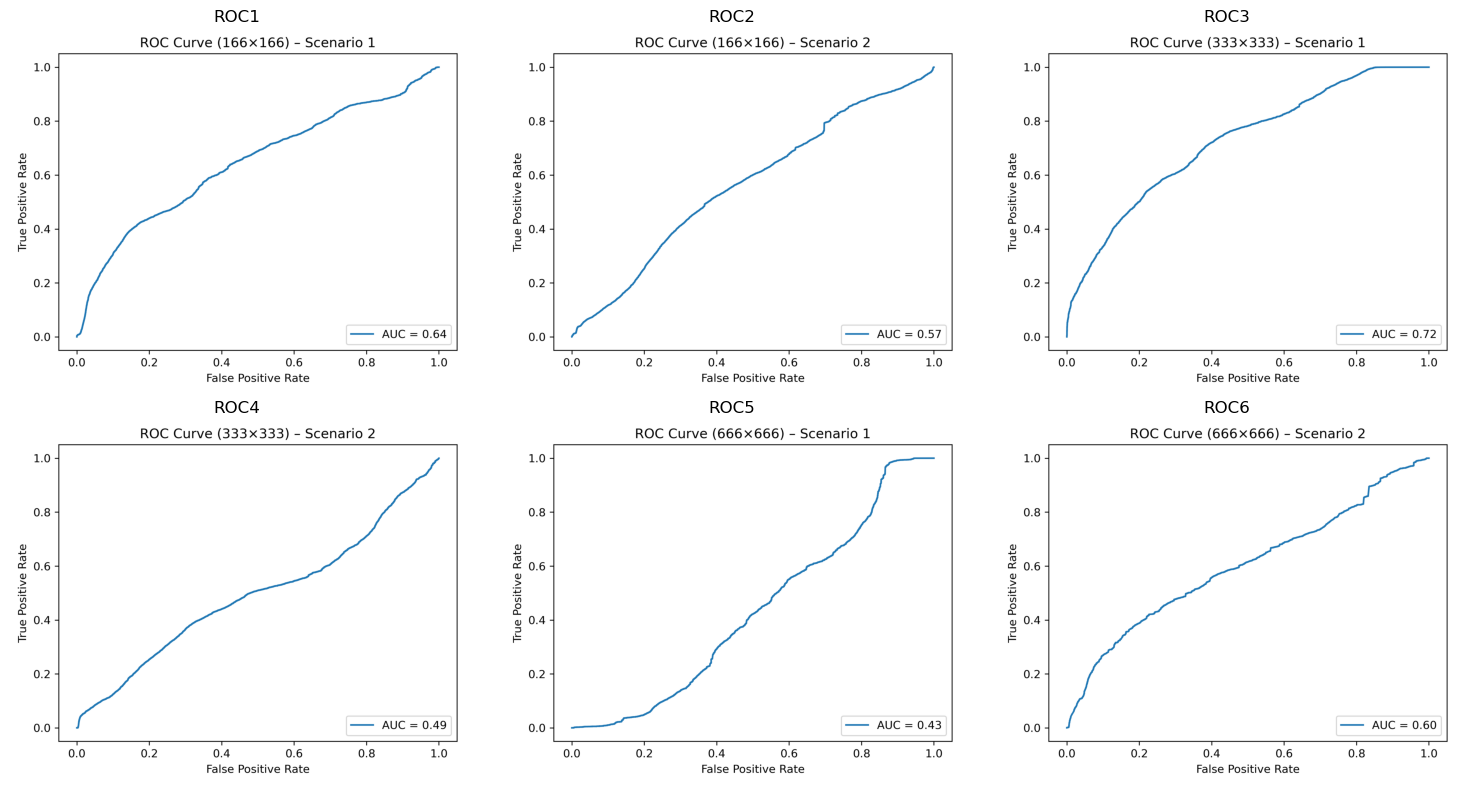

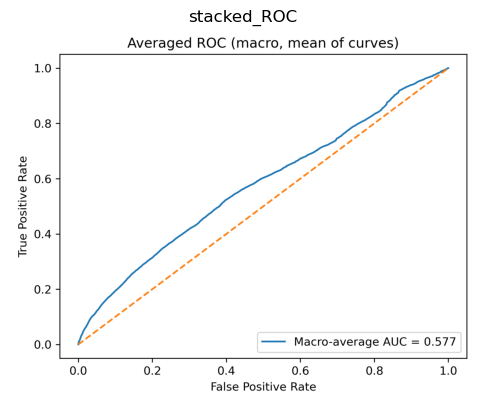

In [21]:
h.display_workflow_outputs('data/ML')
